In [3]:
import sys
sys.path.append("../")

# Look at Simulated Data

In [5]:
%load_ext autoreload
%autoreload 2
from scGraphLLM.utils import simulate_data
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
nclass = 10
ngraphs = 500
nnodes = 10

In [71]:
datasets = simulate_data(num_classes=nclass, graphs_per_class=ngraphs, num_nodes_per_graph=nnodes, 
                         num_edges_per_graph=30, node_embedding_dim=32)

/Users/mingxuanzhang/Desktop/scGraphLLM/notebooks/../scGraphLLM/utils.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_weight = torch.tensor(edge_weight)


In [72]:
from scGraphLLM.utils import CombinedDataset

In [73]:
combined_dataset = CombinedDataset(datasets)

In [74]:
from sklearn.decomposition import PCA

In [75]:
import torch

In [76]:
import numpy as np 

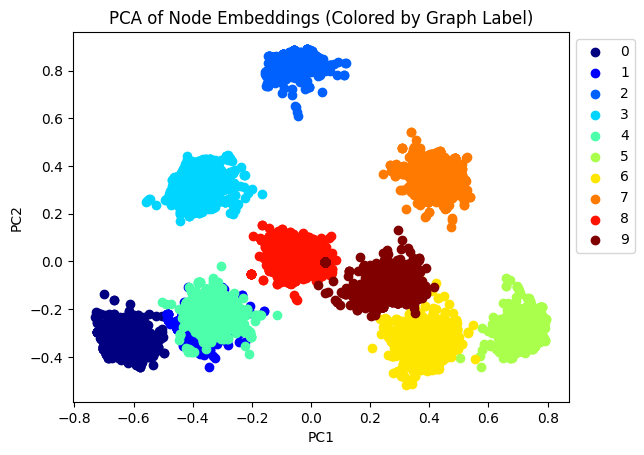

In [77]:
all_embeddings = torch.cat([data.x for data in combined_dataset], dim=0)
all_labels = torch.cat([data.y.repeat(data.x.shape[0]) for data in combined_dataset], dim=0)

pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(all_embeddings)
unique_labels = np.unique(all_labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    plt.scatter(pca_embeddings[all_labels == label, 0], pca_embeddings[all_labels == label, 1], 
                label=label, color=color)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Node Embeddings (Colored by Graph Label)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [78]:
all_embeddings.shape

torch.Size([50000, 32])

# Train GNN on simulation

In [79]:
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split

In [80]:
batch_size = 32
dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

In [81]:
for batch in dataloader:
    print("Number of edges:", batch.edge_index.size(1))
    print("Number of edge attributes:", batch.edge_attr.size(0))
    break

Number of edges: 859
Number of edge attributes: 859


In [82]:
train_size = int(0.6 * len(combined_dataset))
val_size = int(0.3 * len(combined_dataset))
test_size = len(combined_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(combined_dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

In [83]:
len(train_loader)

93

In [84]:
len(val_loader)

46

In [85]:
len(test_loader)

15

In [159]:
from scGraphLLM.config.model_config import GNNConfig
from scGraphLLM.train import TrainerConfig

In [160]:
gnn_config = GNNConfig()
gnn_config.num_nodes = batch_size * nnodes
gnn_config.input_dim = 32
gnn_config.hidden_dims = (128, 128, 128)
gnn_config.conv_dim = 16
gnn_config.out_dim = nclass

In [218]:
train_config = TrainerConfig()
train_config.lr = 5e-3
train_config.num_epochs = 10
train_config.max_grad = 1000.0
train_config.weight_decay = 1e-5
train_config.alpha = 0.001
train_config.verbose = True
train_config.lambda_l1 = 0.01

In [219]:
from scGraphLLM.train import GNN_Trainer

In [220]:
trainer = GNN_Trainer(train_loader, val_loader, gnn_config, train_config)

Number of Attention layers:  4
Number of GNN layers:  5
Number of Batch Normalization layers:  4


In [221]:
model, A, H, Attn, loss_train, loss_val = trainer.train_loop()

[Epoch 0001]  Overall Loss: 0.79586
[Epoch 0001]  Overall val: 0.34055
[Epoch 0002]  Overall Loss: 0.07374
[Epoch 0002]  Overall val: 0.09276
[Epoch 0003]  Overall Loss: 0.03493
[Epoch 0003]  Overall val: 0.05946
[Epoch 0004]  Overall Loss: 0.02858
[Epoch 0004]  Overall val: 0.05522
[Epoch 0005]  Overall Loss: 0.02778
[Epoch 0005]  Overall val: 0.05662
[Epoch 0006]  Overall Loss: 0.02730
[Epoch 0006]  Overall val: 0.05651
[Epoch 0007]  Overall Loss: 0.02719
[Epoch 0007]  Overall val: 0.05333
[Epoch 0008]  Overall Loss: 0.02701
[Epoch 0008]  Overall val: 0.05476
[Epoch 0009]  Overall Loss: 0.02690
[Epoch 0009]  Overall val: 0.05290
[Epoch 0010]  Overall Loss: 0.02652
[Epoch 0010]  Overall val: 0.05538


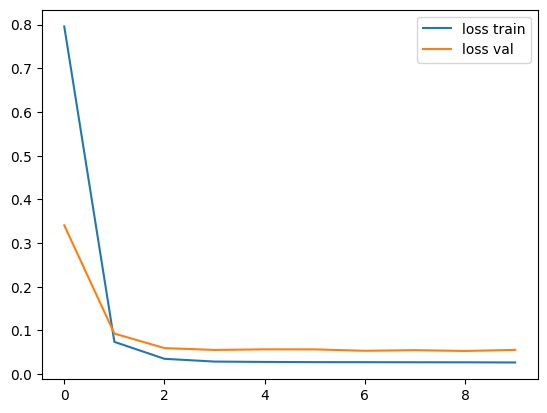

In [223]:
plt.plot(np.clip(loss_train, None, loss_train[0]), label='loss train')
plt.plot(np.clip(loss_val, None, loss_val[0]), label='loss val')
plt.legend()
plt.show()

In [224]:
for data in val_loader:
    data_all = data
    break

In [225]:
data_list = data_all.to_data_list()

In [226]:
graph_id = 2
data_one_graph = data_list[graph_id]
learned_graph = A[0][(10*graph_id) : (10+10*graph_id), (10*graph_id) : (10+10*graph_id)]
learned_graph.shape

torch.Size([10, 10])

In [227]:
from torch_geometric.utils import dense_to_sparse

/var/folders/n0/lbm2yq4n3r1gp83zkf5s69j00000gn/T/ipykernel_33654/3445058960.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


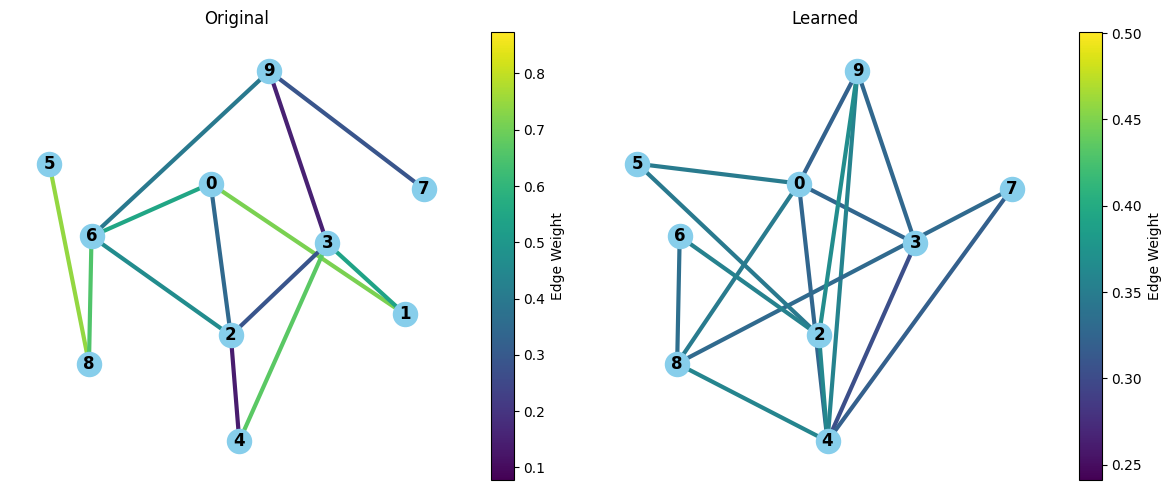

In [228]:
from matplotlib.colors import LinearSegmentedColormap
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes = axes.flatten()
cmap = plt.cm.get_cmap('viridis')

data = data_one_graph
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, k=2)
edge_weights = [data.edge_attr[j].item() for j in range(data.edge_attr.size(0))]
edge_colors = [cmap(weight) for weight in edge_weights]
nx.draw(G, ax=axes[0], pos=pos, with_labels=True, node_color='skyblue', node_size=300, font_weight='bold', width=3, edge_color=edge_colors)
axes[0].set_title("Original")
start = np.min(edge_weights)
end = np.max(edge_weights)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=start, vmax=end))
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes[0])  # Specify the axes for the color bar
cbar.set_label('Edge Weight')


learned, w_learned = dense_to_sparse(learned_graph)
edges = list(zip(learned[0].numpy(), learned[1].numpy()))
G2 = nx.Graph()
G2.add_edges_from(edges)
edge_weights = [w_learned[j].item() for j in range(w_learned.size(0))]

# Create a colormap
start = np.min(edge_weights)
end = np.max(edge_weights)
edge_colors = [cmap(weight) for weight in edge_weights]
nx.draw(G2, pos=pos, ax=axes[1], with_labels=True, node_color='skyblue', node_size=300, 
        font_weight='bold', width=3, edge_color=edge_colors)
axes[1].set_title("Learned")

# Add a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=start, vmax=end))
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes[1])  # Specify the axes for the color bar
cbar.set_label('Edge Weight')


# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [229]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [230]:
model.eval()
accuracies = []
precisions = []
recalls = []
f1_scores = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        h, h_conv, graphs, w = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        y_pred_np = h.argmax(dim=1).detach().numpy()
        y_true_np = batch.y.numpy()

        # Compute metrics for the current batch
        accuracies.append(accuracy_score(y_true_np, y_pred_np))
        precisions.append(precision_score(y_true_np, y_pred_np, zero_division=0, average='macro'))
        recalls.append(recall_score(y_true_np, y_pred_np,  zero_division=0,average='macro'))
        f1_scores.append(f1_score(y_true_np, y_pred_np, average='macro'))


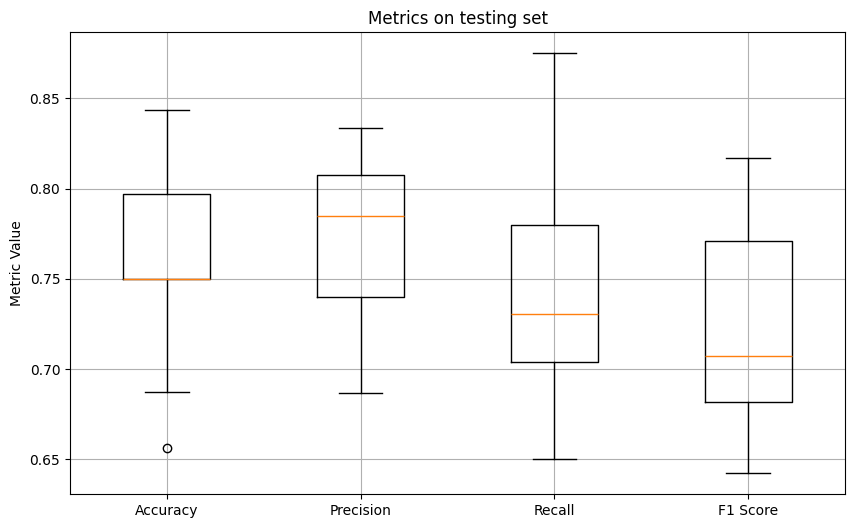

In [231]:
all_metrics = [accuracies, precisions, recalls, f1_scores]
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Create boxplots
plt.figure(figsize=(10, 6))
plt.boxplot(all_metrics, labels=metric_labels)
plt.ylabel('Metric Value')
plt.title('Metrics on testing set')
plt.grid(True)
plt.show()

In [232]:
from sklearn.metrics import roc_curve, auc

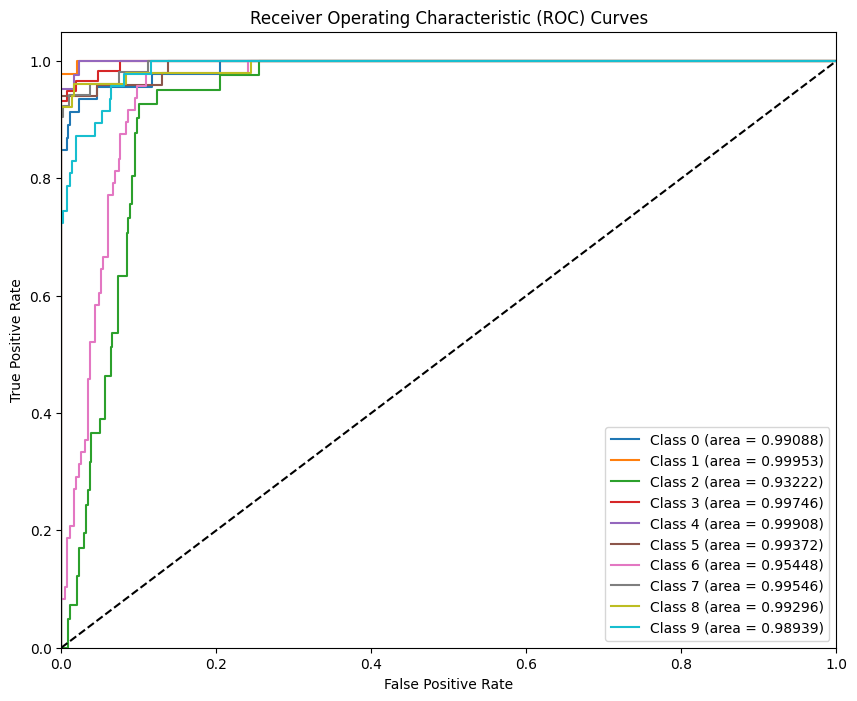

In [233]:
model.eval()
num_classes = 10
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        h, _, _, _ = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        all_preds.append(h)
        all_labels.append(batch.y)

# Concatenate all predictions and labels
all_preds = torch.cat(all_preds, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# One-hot encode the labels
all_labels_one_hot = torch.nn.functional.one_hot(all_labels, num_classes=num_classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_one_hot[:, i].numpy(), all_preds[:, i].numpy())
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.5f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

In [234]:
Attn[0]

tensor([[[[0.5000, 0.5000, 0.5000,  ..., 0.4999, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

         [[0.5000, 0.5000, 0.5000,  ..., 0.5001, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]]],


        [[[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

         [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]]],


        [[[0.5000, 0.5001, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

         [[0.5000, 0.4999, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]]],


        ...,


        [[[0.5000, 0.5001, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

         [[0.5000, 0.4999, 0.5000,  ..., 